In [ ]:
# mount to your drive and access your dataset
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# replace this path to your dataset directory
# DATA_ROOT_DIR="/content/drive/MyDrive/PM2.5/"
DATA_ROOT_DIR="/content/drive/MyDrive/predict-pm2.5-hcm/"
!ls $DATA_ROOT_DIR

'Báo cáo nhóm 11.gdoc'
 clean_data.csv
 data
'LSTM - TSLightGBM'
'Nhóm 11: báo cáo chuẩn bị dữ liệu, kế hoạch implement..gdoc'
 output
 PM2.5_2019.csv
 PM2.5_2020.csv
 PM2.5_2021.csv
'PM2.5 - Xử lý dữ liệu.ipynb'
'run model cmd-colab.ipynb'


In [ ]:
# !unzip /content/drive/MyDrive/PM2.5/data.zip -d /content/drive/MyDrive/PM2.5/

In [ ]:
# Libraries
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

from collections import Counter

# Xử lý tập dữ liệu khí tượng 😎

💪 Gộp tất cả các file data về khí tượng.

In [ ]:
path = DATA_ROOT_DIR + "data/"

all_df = pd.DataFrame(columns=['STN()', 'TIME(DD/HHMM)', 'ALTM(hPa)', 'TMP(C)', 'DEW(C)', 'RH(%)', 'DIR(deg)', 'SPD(m/s)', 'VIS(km)', 'CLOUDS()', 'NA_0()', 'Weather()'])

for filename in glob.glob(os.path.join(path, '*.csv')):
  tmp_df = pd.read_csv(filename)

  # Chỉnh sửa cột `TIME(DD/HHMM)` theo đúng format quy ước
  for i in range(len(tmp_df['TIME(DD/HHMM)'])):
    tmp_df['TIME(DD/HHMM)'][i] = filename[-12:-8] + "-" + filename[-8:-6] + "-" + filename[-6:-4] + " " + tmp_df['TIME(DD/HHMM)'][i][-4:-2] + ":" +  tmp_df['TIME(DD/HHMM)'][i][-2:]

  # Gộp tất cả data lại
  all_df = pd.concat([all_df, tmp_df], ignore_index=True)

# Xóa các dòng trùng giá trị cột `TIME(DD/HHMM)`
all_df.drop_duplicates(subset=['TIME(DD/HHMM)'], inplace=True, ignore_index=True)
all_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,STN(),TIME(DD/HHMM),ALTM(hPa),TMP(C),DEW(C),RH(%),DIR(deg),SPD(m/s),VIS(km),CLOUDS(),NA_0(),Weather(),NA_1(),GUS(m/s)
0,VVTS,2021-07-09 11:00,1006.0,29,23,70,230.0,4,10.0,FEW017,SCT050,NaN,NaN,NaN
1,VVTS,2021-07-09 10:30,1005.0,30,24,70,230.0,4,10.0,FEW017,SCT050,NaN,NaN,NaN
2,VVTS,2021-07-09 10:00,1005.0,30,24,70,230.0,3,10.0,FEW017,SCT050,NaN,NaN,NaN
3,VVTS,2021-07-09 09:30,1005.0,30,24,70,240.0,5,10.0,FEW017,SCT050,NaN,NaN,NaN
4,VVTS,2021-07-09 09:00,1005.0,31,23,62,240.0,6,10.0,FEW017,SCT050,NaN,NaN,NaN


In [ ]:
all_df[~all_df["Weather()"].isna()]

,STN(),TIME(DD/HHMM),ALTM(hPa),TMP(C),DEW(C),RH(%),DIR(deg),SPD(m/s),VIS(km),CLOUDS(),NA_0(),Weather(),NA_1(),GUS(m/s)
24,VVTS,2021-07-09 23:00,1008.0,25,25,100,160.0,3,8.0,SCT015,BKN050,-RA,NaN,NaN
25,VVTS,2021-07-09 22:30,1007.0,25,25,100,NaN,2,10.0,SCT015,SCT050,-RA,NaN,NaN
26,VVTS,2021-07-09 22:00,1007.0,25,25,100,180.0,3,10.0,FEW015,SCT050,-RA,NaN,NaN
170,VVTS,2021-10-27 21:30,1008.0,26,25,94,280.0,1,7.0,FEW015,OVC100,-RA,NaN,NaN
171,VVTS,2021-10-27 21:00,1008.0,26,25,94,310.0,1,7.0,FEW015,OVC100,-RA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9072,VVTS,2021-10-06 13:30,1007.0,25,25,100,230.0,2,8.0,SCT015,BKN050,-RA,NaN,NaN
9073,VVTS,2021-10-06 13:00,1007.0,25,25,100,NaN,1,8.0,SCT015,FEW017,-RA,BKN050,NaN
9074,VVTS,2021-10-06 12:30,1007.0,24,24,100,NaN,1,6.0,SCT015,FEW017,-RA,BKN050,NaN
9075,VVTS,2021-10-06 12:00,1006.0,24,24,100,NaN,1,6.0,SCT015,FEW017,-RA,BKN050,NaN


In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52305 entries, 0 to 52304
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   STN()          52305 non-null  object 
 1   TIME(DD/HHMM)  52305 non-null  object 
 2   ALTM(hPa)      52277 non-null  float64
 3   TMP(C)         52298 non-null  object 
 4   DEW(C)         52289 non-null  object 
 5   RH(%)          52289 non-null  object 
 6   DIR(deg)       40693 non-null  float64
 7   SPD(m/s)       52297 non-null  object 
 8   VIS(km)        52263 non-null  float64
 9   CLOUDS()       51249 non-null  object 
 10  NA_0()         29843 non-null  object 
 11  Weather()      4107 non-null   object 
 12  GUS(m/s)       377 non-null    float64
 13  NA_1()         2781 non-null   object 
dtypes: float64(4), object(10)
memory usage: 5.6+ MB


## Xử lý tập dữ liệu khí tượng 🎨
> Ta thấy, các cột: `NA_0()`, `Weather()`, `GUS(m/s)` và `NA_1()` có lượng dữ liệu bị thiếu rất lớn là 42,94%, 92,15%, 99,28% và 94,68%. 

> Ngoài ra, cột `DIR(deg)` có lượng dữ liệu bị thiếu là 22,2%, các cột còn lại có lượng dữ liệu bị thiếu không quá 2,02% (cột `CLOUDS()`).

👉 Do đó, ta sẽ tiến hành loại bỏ:
* 4 cột có dữ liệu bị thiếu rất lớn là: `NA_0()`, `Weather()`, `GUS(m/s)` và `NA_1()`.
* Cột `STN()` biểu diễn mã danh của trạm đo lường khí tượng tại Tp. Hồ Chí Minh nên ta cũng sẽ loại bỏ cột này do không ảnh hưởng đến chất lượng mô hình.

💥 Ngoài ra, ta sẽ xử lý một số tác vụ sau: 
* Đổi tên cột
* Xóa dòng thừa
* Sắp xếp theo cột `TIME(DD/HHMM)`

In [ ]:
# Xóa cột thừa
all_df = all_df[['TIME(DD/HHMM)', 'ALTM(hPa)', 'TMP(C)', 'DEW(C)', 'RH(%)', 'DIR(deg)', 'SPD(m/s)', 'VIS(km)', 'CLOUDS()']]

# Đổi tên cột
all_df.rename(columns={'TIME(DD/HHMM)':'time',
                       'ALTM(hPa)':'pressure',
                       'TMP(C)':'temperature', 
                       'DEW(C)':'dewpoint_temperature',
                       'RH(%)':'humidity',
                       'DIR(deg)':'wind_direction',
                       'SPD(m/s)':'wind_speed',
                       'VIS(km)':'vision',
                       'CLOUDS()':'clouds'}, inplace=True)

# Xóa dòng thừa
remove = []
for i in range(len(all_df['time'])):
  if all_df['time'][i][-2:] == "30":
    remove.append(i)
all_df.drop(index=remove, inplace=True)
all_df.reset_index(drop=True, inplace=True)

# Sort
all_df.sort_values(by='time', inplace=True, ignore_index=True)
all_df

,time,pressure,temperature,dewpoint_temperature,humidity,wind_direction,wind_speed,vision,clouds
0,2019-01-01 00:00,1013.0,24,18,69,350.0,4,10.0,SCT015
1,2019-01-01 01:00,1014.0,24,18,69,350.0,5,10.0,FEW017
2,2019-01-01 02:00,1014.0,25,19,69,350.0,5,10.0,FEW017
3,2019-01-01 03:00,1014.0,27,19,62,360.0,6,10.0,SCT017
4,2019-01-01 04:00,1014.0,27,19,62,360.0,6,10.0,FEW017
...,...,...,...,...,...,...,...,...,...
26122,2021-12-31 19:00,1013.0,24,18,69,50.0,3,10.0,FEW017
26123,2021-12-31 20:00,1013.0,24,18,69,20.0,3,10.0,FEW017
26124,2021-12-31 21:00,1013.0,24,18,69,20.0,3,10.0,FEW017
26125,2021-12-31 22:00,1013.0,23,18,73,30.0,2,10.0,FEW017


In [ ]:
# Lưu để đỡ phải chạy lại
abc_df = all_df.copy()
# all_df = abc_df.copy()

## Đếm tần suất của các cột `CLOUD()` 🚟

### Cột `CLOUD()` ⛅

🏁 Hàm tính xác suất.

In [ ]:
def value_frequency(list):
  counted = Counter(list)
  value_freq = pd.DataFrame(counted.items(),columns=['value','frequency'])
  return value_freq.sort_values(by='frequency',ascending=False,ignore_index=True)

     value  frequency
0   FEW017       7771
1   SCT017       5070
2   SCT015       4269
3   FEW020       2661
4   BKN017       1982
5   FEW015       1697
6   SCT020        824
7   BKN015        628
8      NaN        520
9   BKN020        261
10  SCT013        246
11  BKN013        125
12  FEW023         23
13  BKN010         23
14  SCT010          9
15  SCT023          3
16  FEW013          3
17  FEW050          2
18  SCT***          2
19  BKN050          2
20  FEW018          1
21  SCT050          1
22  BKN***          1
23  SCT037          1
24  SCT009          1
25  FEW***          1
['FEW017', 'SCT017', 'SCT015', 'FEW020', 'BKN017', 'FEW015', 'SCT020', 'BKN015', nan, 'BKN020', 'SCT013', 'BKN013', 'FEW023', 'BKN010', 'SCT010', 'SCT023', 'FEW013', 'FEW050', 'SCT***', 'BKN050', 'FEW018', 'SCT050', 'BKN***', 'SCT037', 'SCT009', 'FEW***']


Text(0, 0.5, 'frequency')

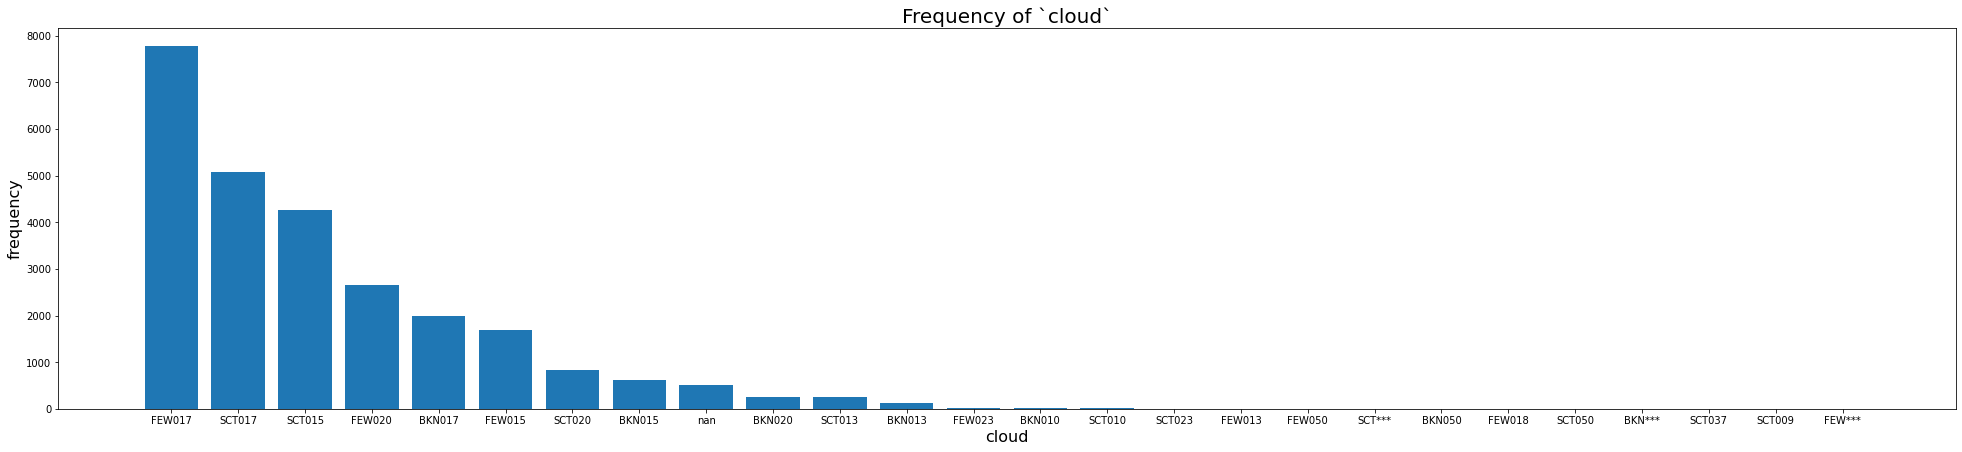

In [ ]:
cloud_freq = value_frequency(all_df['clouds'])

print(cloud_freq)
print([v for v in cloud_freq["value"]])

# Plot
fig, ax = plt.subplots(figsize=(34, 7))
plt.bar(x=cloud_freq["value"].astype(str), height=cloud_freq["frequency"])
plt.title("Frequency of `cloud`", fontsize=20)
plt.xlabel("cloud", fontsize=16)
plt.ylabel("frequency", fontsize=16)

🔢 Số hóa cột `clouds`.

In [ ]:
clouds_dict = {'BKN010':0, 'BKN013': 1, 'BKN015': 2, 'BKN017':3, 'BKN020':4, 'BKN050':5, 'BKN***':6, 'FEW013':7, 'FEW015':8, 'FEW017':9, 'FEW018':10, 'FEW020':11, 'FEW023':12, 'FEW050':13, 'FEW***':14, 'SCT009':15, 'SCT010':16, 'SCT013':17, 'SCT015':18, 'SCT017':19, 'SCT020':20, 'SCT023':21, 'SCT037':22, 'SCT050':23, 'SCT***':24}
all_df.replace({'clouds': clouds_dict}, inplace=True)
all_df

,time,pressure,temperature,dewpoint_temperature,humidity,wind_direction,wind_speed,vision,clouds
0,2019-01-01 00:00,1013.0,24,18,69,350.0,4,10.0,18.0
1,2019-01-01 01:00,1014.0,24,18,69,350.0,5,10.0,9.0
2,2019-01-01 02:00,1014.0,25,19,69,350.0,5,10.0,9.0
3,2019-01-01 03:00,1014.0,27,19,62,360.0,6,10.0,19.0
4,2019-01-01 04:00,1014.0,27,19,62,360.0,6,10.0,9.0
...,...,...,...,...,...,...,...,...,...
26122,2021-12-31 19:00,1013.0,24,18,69,50.0,3,10.0,9.0
26123,2021-12-31 20:00,1013.0,24,18,69,20.0,3,10.0,9.0
26124,2021-12-31 21:00,1013.0,24,18,69,20.0,3,10.0,9.0
26125,2021-12-31 22:00,1013.0,23,18,73,30.0,2,10.0,9.0


# Xử lý tập dữ liệu nồng độ PM2.5 🎍

* Gộp các file dữ liệu nồng độ PM2.5
* Sửa cột `Date (LT)` theo format thời gian quy ước
* Chỉ lấy 2 cột có giá trị trong việc huấn luyện mô hình: `Date (LT)` và `Raw Conc.`
* Xóa các cột cùng giá trị cột `Date (LT)`
* Đổi tên cột

In [ ]:
# pm25_2019_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2019.csv")
# pm25_2020_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2020.csv")
# pm25_2021_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2021.csv")

# pm25_df = pd.concat([pm25_2019_df, pm25_2020_df, pm25_2021_df], ignore_index=True)

# # Ghép cột `Year`, `Month`, `Day`, `Hour` thành format quy ước
# for i in range(len(pm25_df)):
#   pm25_df['Date (LT)'][i] = str(pm25_df['Year'][i]) + "-" + str(pm25_df['Month'][i]).rjust(2, '0') + "-" + str(pm25_df['Day'][i]).rjust(2, '0') + " " +  str(pm25_df['Hour'][i]).rjust(2, '0') + ":00"

# # Chỉ lấy giá trị 2 cột `Date (LT)` và `Raw Conc.`
# pm25_df = pm25_df[['Date (LT)', 'Raw Conc.', 'NowCast Conc.', 'AQI', 'AQI Category', 'QC Name']]

# # Xóa các dòng trùng giá trị cột `Date (LT)`
# pm25_df.drop_duplicates(subset=['Date (LT)'], inplace=True, ignore_index=True)

# # Đổi tên cột
# pm25_df.rename(columns = {'Date (LT)':'time','Raw Conc.':'PM25_Concentration'}, inplace=True)
# pm25_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,time,PM25_Concentration,NowCast Conc.,AQI,AQI Category,QC Name
0,2019-01-01 01:00,10.0,12.5,52,Moderate,Valid
1,2019-01-01 02:00,12.0,12.2,51,Moderate,Valid
2,2019-01-01 03:00,11.0,11.6,48,Good,Valid
3,2019-01-01 04:00,8.0,9.8,41,Good,Valid
4,2019-01-01 05:00,14.0,11.9,50,Good,Valid
...,...,...,...,...,...,...
25903,2021-12-31 20:00,28.0,24.2,76,Moderate,Valid
25904,2021-12-31 21:00,30.0,27.1,83,Moderate,Valid
25905,2021-12-31 22:00,23.0,25.0,78,Moderate,Valid
25906,2021-12-31 23:00,19.0,22.0,72,Moderate,Valid


In [ ]:
pm25_2019_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2019.csv")
pm25_2020_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2020.csv")
pm25_2021_df = pd.read_csv(DATA_ROOT_DIR + "/PM2.5_2021.csv")

pm25_df = pd.concat([pm25_2019_df, pm25_2020_df, pm25_2021_df], ignore_index=True)

# Ghép cột `Year`, `Month`, `Day`, `Hour` thành format quy ước
for i in range(len(pm25_df)):
  pm25_df['Date (LT)'][i] = str(pm25_df['Year'][i]) + "-" + str(pm25_df['Month'][i]).rjust(2, '0') + "-" + str(pm25_df['Day'][i]).rjust(2, '0') + " " +  str(pm25_df['Hour'][i]).rjust(2, '0') + ":00"

# Chỉ lấy giá trị 2 cột `Date (LT)` và `Raw Conc.`
pm25_df = pm25_df[['Date (LT)', 'Raw Conc.']]

# Xóa các dòng trùng giá trị cột `Date (LT)`
pm25_df.drop_duplicates(subset=['Date (LT)'], inplace=True, ignore_index=True)

# Đổi tên cột
pm25_df.rename(columns = {'Date (LT)':'time','Raw Conc.':'PM25_Concentration'}, inplace=True)
pm25_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,time,PM25_Concentration
0,2019-01-01 01:00,10.0
1,2019-01-01 02:00,12.0
2,2019-01-01 03:00,11.0
3,2019-01-01 04:00,8.0
4,2019-01-01 05:00,14.0
...,...,...
25903,2021-12-31 20:00,28.0
25904,2021-12-31 21:00,30.0
25905,2021-12-31 22:00,23.0
25906,2021-12-31 23:00,19.0


🧨 Nối tập dữ liệu khí tượng và tập dữ liệu nồng độ PM2.5.

In [ ]:
result_df = pm25_df.merge(all_df, on='time')
result_df = result_df[['time', 'temperature', 'dewpoint_temperature', 'pressure', 'humidity', 'wind_speed', 'wind_direction', 'vision', 'clouds', 'PM25_Concentration']]
result_df

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
0,2019-01-01 01:00,24,18,1014.0,69,5,350.0,10.0,9.0,10.0
1,2019-01-01 02:00,25,19,1014.0,69,5,350.0,10.0,9.0,12.0
2,2019-01-01 03:00,27,19,1014.0,62,6,360.0,10.0,19.0,11.0
3,2019-01-01 04:00,27,19,1014.0,62,6,360.0,10.0,9.0,8.0
4,2019-01-01 05:00,28,20,1013.0,62,5,350.0,10.0,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...
25725,2021-12-31 19:00,24,18,1013.0,69,3,50.0,10.0,9.0,21.0
25726,2021-12-31 20:00,24,18,1013.0,69,3,20.0,10.0,9.0,28.0
25727,2021-12-31 21:00,24,18,1013.0,69,3,20.0,10.0,9.0,30.0
25728,2021-12-31 22:00,23,18,1013.0,73,2,30.0,10.0,9.0,23.0


📂 Có một vài dữ liệu về hướng gió và nồng độ PM2.5 bị lỗi nên ta sẽ tiến hành thay thế các giá trị hướng gió nằm ngoài [0, 360] và các giá trị nồng độ PM2.5 nằm ngoài khoảng [0, 500] thành NaN.

In [ ]:
# Thay thế
result_df['PM25_Concentration'] = result_df['PM25_Concentration'].apply(lambda x : np.nan if x < 0 else x)
result_df['PM25_Concentration'] = result_df['PM25_Concentration'].apply(lambda x : np.nan if x > 500 else x)

result_df['wind_direction'] = result_df['wind_direction'].apply(lambda x : 0 if x == 360 else x)
result_df['wind_direction'] = result_df['wind_direction'].apply(lambda x : np.nan if x < 0 else x)
result_df['wind_direction'] = result_df['wind_direction'].apply(lambda x : np.nan if x >= 360 else x)

result_df.reset_index(drop=True, inplace=True)
result_df

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
0,2019-01-01 01:00,24,18,1014.0,69,5,350.0,10.0,9.0,10.0
1,2019-01-01 02:00,25,19,1014.0,69,5,350.0,10.0,9.0,12.0
2,2019-01-01 03:00,27,19,1014.0,62,6,0.0,10.0,19.0,11.0
3,2019-01-01 04:00,27,19,1014.0,62,6,0.0,10.0,9.0,8.0
4,2019-01-01 05:00,28,20,1013.0,62,5,350.0,10.0,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...
25725,2021-12-31 19:00,24,18,1013.0,69,3,50.0,10.0,9.0,21.0
25726,2021-12-31 20:00,24,18,1013.0,69,3,20.0,10.0,9.0,28.0
25727,2021-12-31 21:00,24,18,1013.0,69,3,20.0,10.0,9.0,30.0
25728,2021-12-31 22:00,23,18,1013.0,73,2,30.0,10.0,9.0,23.0


In [ ]:
# Lưu lại để lỡ bị lỗi thì không phải chạy lại từ đầu
def_df = result_df.copy()
# result_df = def_df.copy()

# Xử lý những khoảng thời gian bị thiếu trong data 🕒

🎶 Tạo _1 dataframe_ có chứa đầy đủ tất cả các giờ trong khoảng thời gian _2019-01-01 01:00_ đến _2021-12-31 23:00_.

In [ ]:
# Số ngày trong tháng lần lượt từ 2019 -> 2021
day_num = [31,28,31,30,31,30,31,31,30,31,30,31,31,29,31,30,31,30,31,31,30,31,30,31,31,28,31,30,31,30,31,31,30,31,30,31]
arr = []
year = 2018

for i in range(len(day_num)):
  if i % 12 == 0:
    year+=1
  for j in range(day_num[i]):
    for k in range(24):
      arr.append(str(year) + "-" + str(i%12+1).rjust(2, '0') + "-" + str(j+1).rjust(2, '0') + " " + str(k).rjust(2, '0') + ":00")

day_num_df = pd.DataFrame(columns=['time'])
day_num_df['time'] = arr[1:]
day_num_df

,time
0,2019-01-01 01:00
1,2019-01-01 02:00
2,2019-01-01 03:00
3,2019-01-01 04:00
4,2019-01-01 05:00
...,...
26298,2021-12-31 19:00
26299,2021-12-31 20:00
26300,2021-12-31 21:00
26301,2021-12-31 22:00


🎭 Những giờ bị thiếu.

In [ ]:
lost_hour_df = day_num_df[~day_num_df['time'].isin(result_df['time'])].dropna()
lost_hour_df

,time
66,2019-01-03 19:00
67,2019-01-03 20:00
68,2019-01-03 21:00
69,2019-01-03 22:00
70,2019-01-03 23:00
...,...
24679,2021-10-25 08:00
24681,2021-10-25 10:00
24724,2021-10-27 05:00
25379,2021-11-23 12:00


🧇 Thống kê.

In [ ]:
lost_month_df = pd.DataFrame(columns=['time'])
lost_month_df['time'] = lost_hour_df['time'].astype(str).str[:7]

lost_month_freq = value_frequency(lost_month_df['time']).sort_values(by='value',ignore_index=True)
count = 0

for m in lost_month_freq.value:
  print(f'{m}:')
  h_lost = []
  for h in lost_hour_df['time']:
    if h[:7] == m:
      if h_lost and h_lost[-1][:2] != h[8:10]:
        print(f'\t{h_lost}')
        count += len(h_lost)
        h_lost = []
      h_lost.append(h[8:])
  print(f'\t{h_lost}')
  count += len(h_lost)

print(count == len(lost_hour_df))

2019-01:
	['03 19:00', '03 20:00', '03 21:00', '03 22:00', '03 23:00']
	['04 00:00', '04 01:00', '04 02:00', '04 03:00', '04 04:00', '04 05:00', '04 06:00', '04 07:00', '04 08:00', '04 09:00', '04 10:00', '04 11:00', '04 12:00', '04 13:00']
	['06 00:00']
	['18 05:00']
	['22 22:00', '22 23:00']
	['23 00:00']
	['24 00:00']
2019-02:
	['01 05:00']
	['13 12:00']
	['19 17:00', '19 18:00', '19 19:00']
2019-03:
	['01 15:00']
	['10 02:00']
	['23 15:00', '23 16:00', '23 17:00', '23 18:00', '23 19:00', '23 20:00', '23 21:00', '23 22:00', '23 23:00']
	['24 00:00', '24 01:00', '24 02:00', '24 03:00', '24 04:00', '24 05:00', '24 06:00', '24 07:00', '24 08:00', '24 09:00', '24 10:00', '24 11:00', '24 12:00', '24 13:00', '24 14:00', '24 15:00', '24 16:00', '24 17:00', '24 18:00', '24 19:00', '24 20:00', '24 21:00', '24 22:00', '24 23:00']
	['25 00:00', '25 01:00', '25 02:00', '25 03:00', '25 04:00', '25 05:00', '25 06:00', '25 07:00', '25 08:00', '25 09:00', '25 10:00', '25 11:00', '25 12:00', '25 13:

In [ ]:
# Nối các ngày còn thiếu
result_df = pd.concat([result_df, lost_hour_df], ignore_index=True)

# Thay thế các giá trị NaN về cùng format np.nan
result_df = result_df.fillna(np.nan)

result_df.sort_values(by='time', inplace=True, ignore_index=True)
result_df

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
0,2019-01-01 01:00,24.0,18.0,1014.0,69.0,5.0,350.0,10.0,9.0,10.0
1,2019-01-01 02:00,25.0,19.0,1014.0,69.0,5.0,350.0,10.0,9.0,12.0
2,2019-01-01 03:00,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,19.0,11.0
3,2019-01-01 04:00,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,9.0,8.0
4,2019-01-01 05:00,28.0,20.0,1013.0,62.0,5.0,350.0,10.0,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...
26298,2021-12-31 19:00,24.0,18.0,1013.0,69.0,3.0,50.0,10.0,9.0,21.0
26299,2021-12-31 20:00,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,28.0
26300,2021-12-31 21:00,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,30.0
26301,2021-12-31 22:00,23.0,18.0,1013.0,73.0,2.0,30.0,10.0,9.0,23.0


💤 Thống kê các dòng có chứa giá trị NaN.

In [ ]:
result_df[result_df.isnull().any(axis=1)]

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,PM25_Concentration
50,2019-01-03 03:00,28.0,21.0,1014.0,66.0,2.0,NaN,10.0,19.0
62,2019-01-03 15:00,25.0,22.0,1013.0,83.0,3.0,20.0,10.0,NaN
63,2019-01-03 16:00,24.0,22.0,1012.0,89.0,3.0,10.0,10.0,NaN
64,2019-01-03 17:00,24.0,21.0,1012.0,83.0,2.0,NaN,10.0,NaN
65,2019-01-03 18:00,24.0,21.0,1012.0,83.0,1.0,NaN,10.0,NaN
...,...,...,...,...,...,...,...,...,...
26249,2021-12-29 18:00,24.0,24.0,1012.0,100.0,1.0,NaN,10.0,23.0
26250,2021-12-29 19:00,24.0,24.0,1012.0,100.0,1.0,NaN,8.0,29.0
26255,2021-12-30 00:00,24.0,20.0,1014.0,78.0,1.0,NaN,10.0,13.0
26267,2021-12-30 12:00,28.0,21.0,1012.0,66.0,2.0,40.0,10.0,NaN


👉 Ta sẽ áp dụng kỹ thuật `Linear Interpolation` để xử lý dữ liệu bị lỗi NaN với `window_size=3`.

In [ ]:
for i in range(1, len(result_df) - 1):
  for col in result_df.columns:
    if col != 'time':
      if not np.isnan(result_df[col][i-1]) and not np.isnan(result_df[col][i+1]) and np.isnan(result_df[col][i]):
        result_df[col][i] = (result_df[col][i-1] + result_df[col][i+1]) / 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


💌 Sau khi xử lý xong, ta thống kê lại các dòng có chứa giá trị NaN.

In [ ]:
result_df[result_df.isnull().any(axis=1)]

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
62,2019-01-03 15:00,25.0,22.0,1013.0,83.0,3.0,20.0,10.0,18.0,NaN
63,2019-01-03 16:00,24.0,22.0,1012.0,89.0,3.0,10.0,10.0,19.0,NaN
64,2019-01-03 17:00,24.0,21.0,1012.0,83.0,2.0,NaN,10.0,19.0,NaN
65,2019-01-03 18:00,24.0,21.0,1012.0,83.0,1.0,NaN,10.0,19.0,NaN
66,2019-01-03 19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
26229,2021-12-28 22:00,25.0,25.0,1012.0,100.0,1.0,NaN,7.0,9.0,47.0
26247,2021-12-29 16:00,25.0,24.0,1013.0,94.0,1.0,NaN,10.0,18.0,14.0
26248,2021-12-29 17:00,25.0,24.0,1013.0,94.0,1.0,NaN,10.0,18.0,16.0
26249,2021-12-29 18:00,24.0,24.0,1012.0,100.0,1.0,NaN,10.0,18.0,23.0


🧭 Tập dữ liệu còn lại sẽ chứa ít nhất 2 giá trị NaN cạnh nhau, không thể xử lý được với `window_size=3`. Do đó, ta sẽ tiến hành loại bỏ chúng. 

In [ ]:
result_df = result_df.dropna()
result_df.reset_index(drop=True, inplace=True)
result_df[result_df.isnull().any(axis=1)]

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration


In [ ]:
result_df

,time,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
0,2019-01-01 01:00,24.0,18.0,1014.0,69.0,5.0,350.0,10.0,9.0,10.0
1,2019-01-01 02:00,25.0,19.0,1014.0,69.0,5.0,350.0,10.0,9.0,12.0
2,2019-01-01 03:00,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,19.0,11.0
3,2019-01-01 04:00,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,9.0,8.0
4,2019-01-01 05:00,28.0,20.0,1013.0,62.0,5.0,350.0,10.0,19.0,14.0
...,...,...,...,...,...,...,...,...,...,...
21081,2021-12-31 19:00,24.0,18.0,1013.0,69.0,3.0,50.0,10.0,9.0,21.0
21082,2021-12-31 20:00,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,28.0
21083,2021-12-31 21:00,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,30.0
21084,2021-12-31 22:00,23.0,18.0,1013.0,73.0,2.0,30.0,10.0,9.0,23.0


## Đếm tần suất của các cột `CLOUD()` và `wind_direction` 🎃

### Cột `wind_direction` 🎯

    value  frequency
0     0.0        725
1     5.0         15
2    10.0        324
3    15.0         18
4    20.0        377
..    ...        ...
66  330.0        256
67  335.0          5
68  340.0        178
69  345.0          5
70  350.0        240

[71 rows x 2 columns]


Text(0, 0.5, 'frequency')

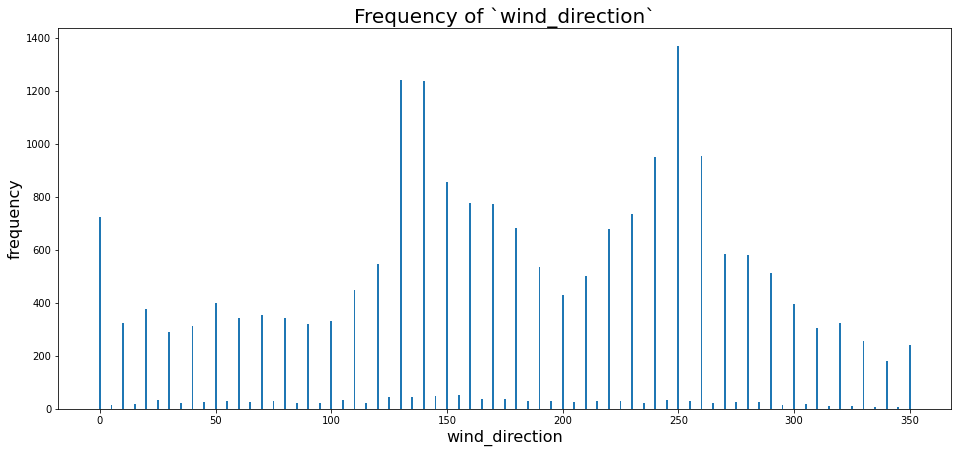

In [ ]:
dir_freq = value_frequency(result_df['wind_direction']).sort_values(by='value',ignore_index=True)
print(dir_freq)

# Plot
fig, ax = plt.subplots(figsize=(16, 7))
plt.bar(x=dir_freq["value"], height=dir_freq["frequency"])
plt.title("Frequency of `wind_direction`", fontsize=20)
plt.xlabel("wind_direction", fontsize=16)
plt.ylabel("frequency", fontsize=16)

# Tìm tương quan giữa các đặc trưng 🚧

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

In [ ]:
tmp_df = result_df[['temperature','dewpoint_temperature','pressure','humidity','wind_speed','wind_direction','vision','clouds','PM25_Concentration']]
tmp_df

,temperature,dewpoint_temperature,pressure,humidity,wind_speed,wind_direction,vision,clouds,PM25_Concentration
0,24.0,18.0,1014.0,69.0,5.0,350.0,10.0,9.0,10.0
1,25.0,19.0,1014.0,69.0,5.0,350.0,10.0,9.0,12.0
2,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,19.0,11.0
3,27.0,19.0,1014.0,62.0,6.0,0.0,10.0,9.0,8.0
4,28.0,20.0,1013.0,62.0,5.0,350.0,10.0,19.0,14.0
...,...,...,...,...,...,...,...,...,...
21081,24.0,18.0,1013.0,69.0,3.0,50.0,10.0,9.0,21.0
21082,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,28.0
21083,24.0,18.0,1013.0,69.0,3.0,20.0,10.0,9.0,30.0
21084,23.0,18.0,1013.0,73.0,2.0,30.0,10.0,9.0,23.0


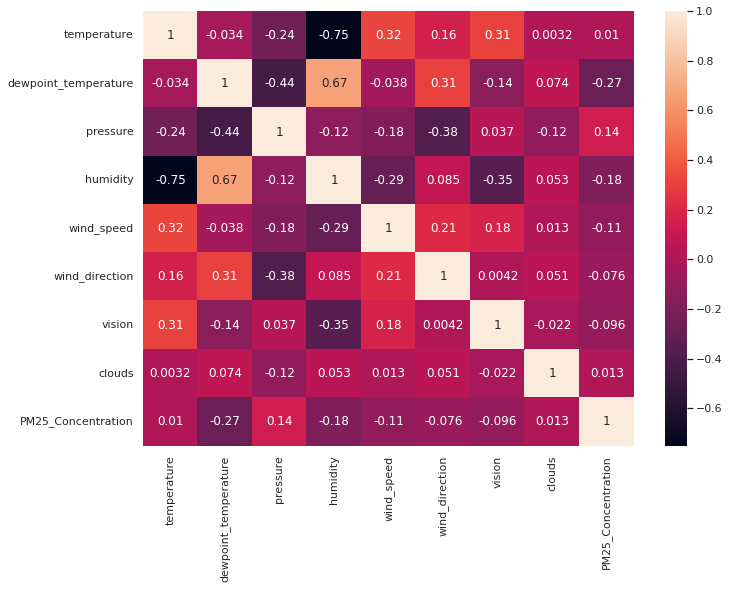

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(tmp_df.corr(), annot=True)

# Xuất ra file `.csv` 🚀

In [ ]:
result_df.to_csv(DATA_ROOT_DIR+"/clean_data.csv", index=False)